In [1]:
import numpy as np
import pandas as pd
# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


# XGBoost(    booster='dart',   tree_method='auto',     eval_metric='logloss')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import xgboost as xgb
from sklearn.model_selection import train_test_split

# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)



# === XGBoost Classifier with booster='dart' and tree_method='auto' ===
xgb_model = xgb.XGBClassifier(
    booster='dart',
    tree_method='auto',
    eval_metric='logloss',
    random_state=42
)

# === Pipeline: Raw -> RF selector -> Scaler -> XGBoost ===
pipeline = Pipeline([('xgb', xgb_model)])

# === Param Grid for XGBoost ===
param_grid = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__reg_alpha': [0, 0.1, 0.3, 0.5, 0.7, 1],       # L1 regularization
    'xgb__reg_lambda': [1, 2, 5],        # L2 regularization
    'xgb__scale_pos_weight': [(len(y_train) - sum(y_train)) / sum(y_train)],
    
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


#===plotting feature importance of best model===

# Extract the best XGBoost model from the pipeline
best_xgb_model = grid_p.best_estimator_.named_steps['xgb']

# Plot feature importance (default: based on weight)
xgb.plot_importance(best_xgb_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance (by weight)")
plt.show()

# You can also plot by other importance types, e.g., 'gain' or 'cover':
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (by gain)")
plt.show()

xgb.plot_importance(best_xgb_model, importance_type='cover', max_num_features=20)
plt.title("Feature Importance (by cover)")
plt.show()





In [ ]:


### ✅ 1. SHAP Interpretation for Feature Contributions
import shap

# === SHAP Interpretation ===
# Use TreeExplainer for XGBoost
explainer = shap.Explainer(best_xgb_model, X_train, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_train)

# === SHAP Summary Plot ===
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)  # Bar plot of mean(|SHAP|) per feature
shap.summary_plot(shap_values, X_train, show=True)                   # Beeswarm plot


### 🔧 Optional: SHAP Force Plot (if Jupyter/Notebook)
# Only works in Jupyter/Notebook environments
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])



In [ ]:
### ✅ 2. Learning Curve Visualization


from sklearn.model_selection import learning_curve

# === Learning Curve ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=grid_p.best_estimator_,
    X=X_train,
    y=y_train,
    cv=cv,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve (Best XGBoost Model)")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()




In [ ]:
from xgboost import plot_tree
### 🔁 Optionally: Loop Through Multiple Trees
# Plot first 3 trees
for i in range(3):
    plt.figure(figsize=(20, 10))
    plot_tree(best_xgb_model, num_trees=i, rankdir='LR')
    plt.title(f"Tree {i} from Best XGBoost Model")
    plt.tight_layout()
    plt.show()

# BayesSearchCV

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

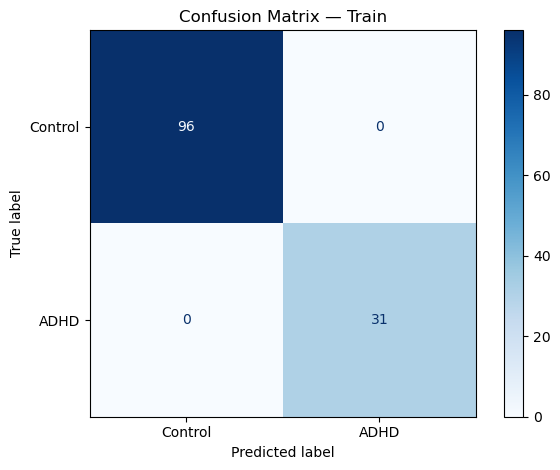

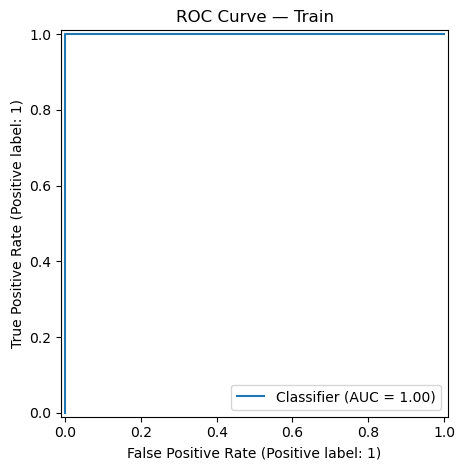

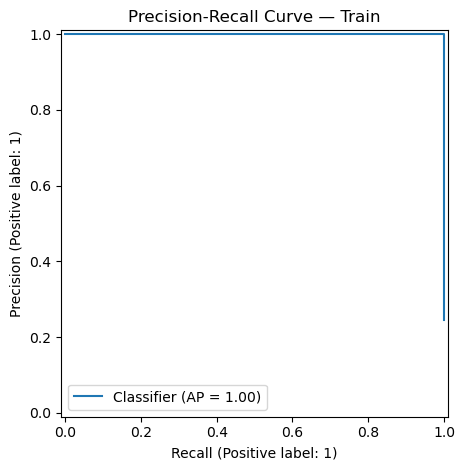


📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.82      0.96      0.88        24
        ADHD       0.75      0.38      0.50         8

    accuracy                           0.81        32
   macro avg       0.79      0.67      0.69        32
weighted avg       0.80      0.81      0.79        32

ROC AUC (Test): 0.7604166666666667


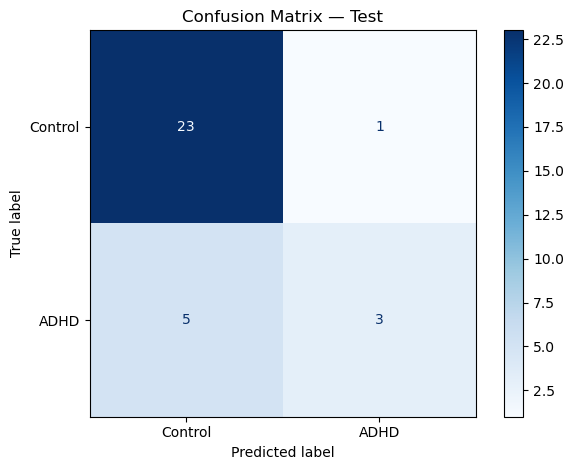

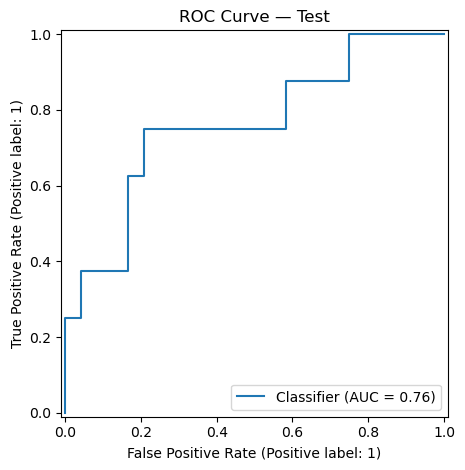

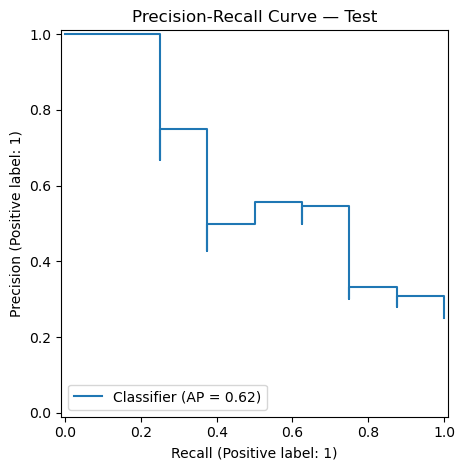

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.3431
score_time: 0.0821
test_accuracy: 0.7300
train_accuracy: 1.0000
test_precision_macro: 0.5290
train_precision_macro: 1.0000
test_recall_macro: 0.5625
train_recall_macro: 1.0000
test_f1_macro: 0.5402
train_f1_macro: 1.0000
test_roc_auc: 0.6292
train_roc_auc: 1.0000


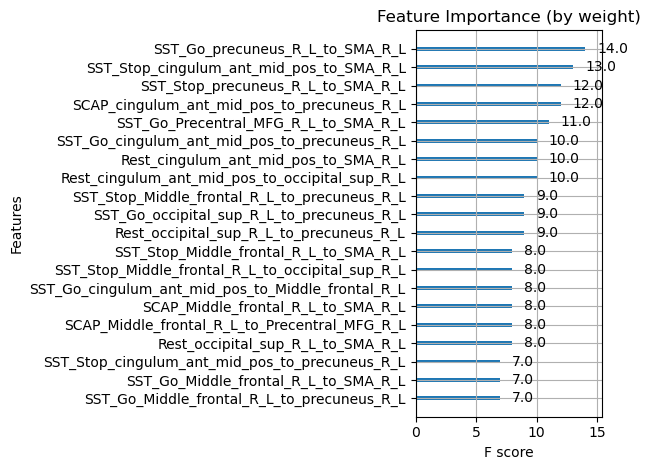

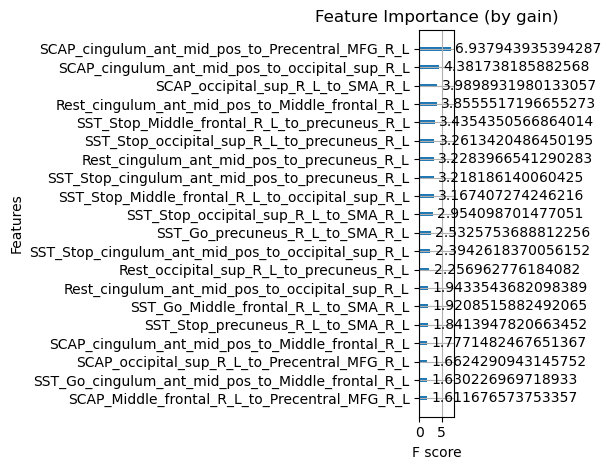

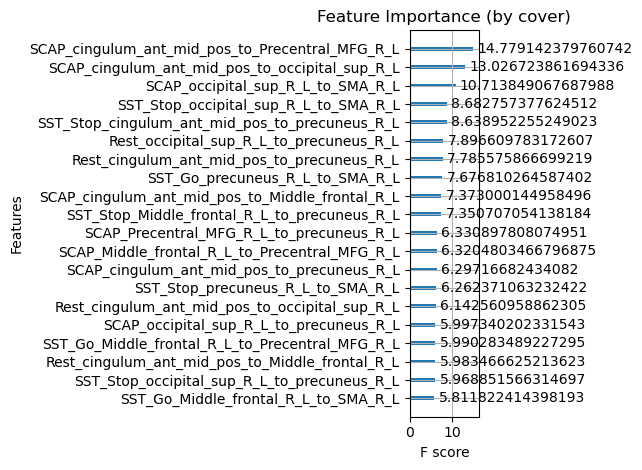

In [35]:


### 🧠 **REVISED CODE USING BAYESIAN OPTIMIZATION**


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import xgboost as xgb

# === STEP 1: Prepare Features and Labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-Test Split ===
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === STEP 3: Cross-Validation Strategy ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === STEP 4: Model Definition ===
xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    tree_method='auto',
    eval_metric='logloss',
    random_state=42
)

pipeline = Pipeline([('xgb', xgb_model)])

# === STEP 5: Bayesian Hyperparameter Search Space ===
scale_pos_weight_val = (len(y_train) - sum(y_train)) / sum(y_train)

search_space = {
    'xgb__n_estimators': Integer(50, 300),
    'xgb__max_depth': Integer(3, 10),
    'xgb__learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'xgb__subsample': Real(0.6, 1.0),
    'xgb__colsample_bytree': Real(0.6, 1.0),
    'xgb__reg_alpha': Real(0.0, 1.0),
    'xgb__reg_lambda': Real(1.0, 10.0),
    'xgb__scale_pos_weight': [scale_pos_weight_val]
}

# === STEP 6: Bayesian Optimization ===
opt = BayesSearchCV(
    estimator=pipeline,
    search_spaces=search_space,
    n_iter=50,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

opt.fit(X_train, y_train)
print("✅ Best Params:", opt.best_params_)

# === STEP 7: Evaluation Function ===
def evaluate_model(y_true, y_pred, y_proba, dataset="Train"):
    print(f"\n📘 Classification Report ({dataset}):")
    print(classification_report(y_true, y_pred, target_names=['Control', 'ADHD']))
    print(f"ROC AUC ({dataset}):", roc_auc_score(y_true, y_proba))

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
    plt.title(f"Confusion Matrix — {dataset}")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"ROC Curve — {dataset}")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_proba)
    plt.title(f"Precision-Recall Curve — {dataset}")
    plt.tight_layout()
    plt.show()

# === STEP 8: Train Evaluation ===
y_train_pred = opt.predict(X_train)
y_train_proba = opt.predict_proba(X_train)[:, 1]
evaluate_model(y_train, y_train_pred, y_train_proba, "Train")

# === STEP 9: Test Evaluation ===
y_test_pred = opt.predict(X_test)
y_test_proba = opt.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_test_pred, y_test_proba, "Test")

# === STEP 10: Cross-Validated Performance on All Data ===
cv_scores = cross_validate(
    opt.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === STEP 11: Feature Importance ===
best_xgb_model = opt.best_estimator_.named_steps['xgb']

for importance_type in ['weight', 'gain', 'cover']:
    xgb.plot_importance(best_xgb_model, importance_type=importance_type, max_num_features=20)
    plt.title(f"Feature Importance (by {importance_type})")
    plt.tight_layout()
    plt.show()


**SHAP**

🔍 Computing SHAP values...


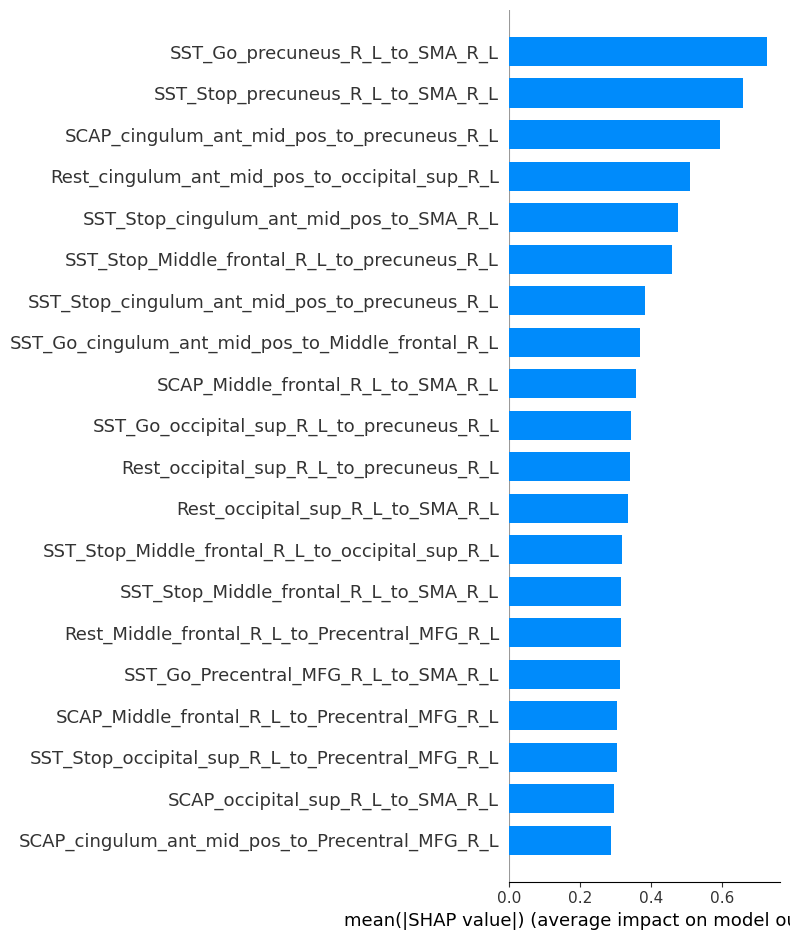

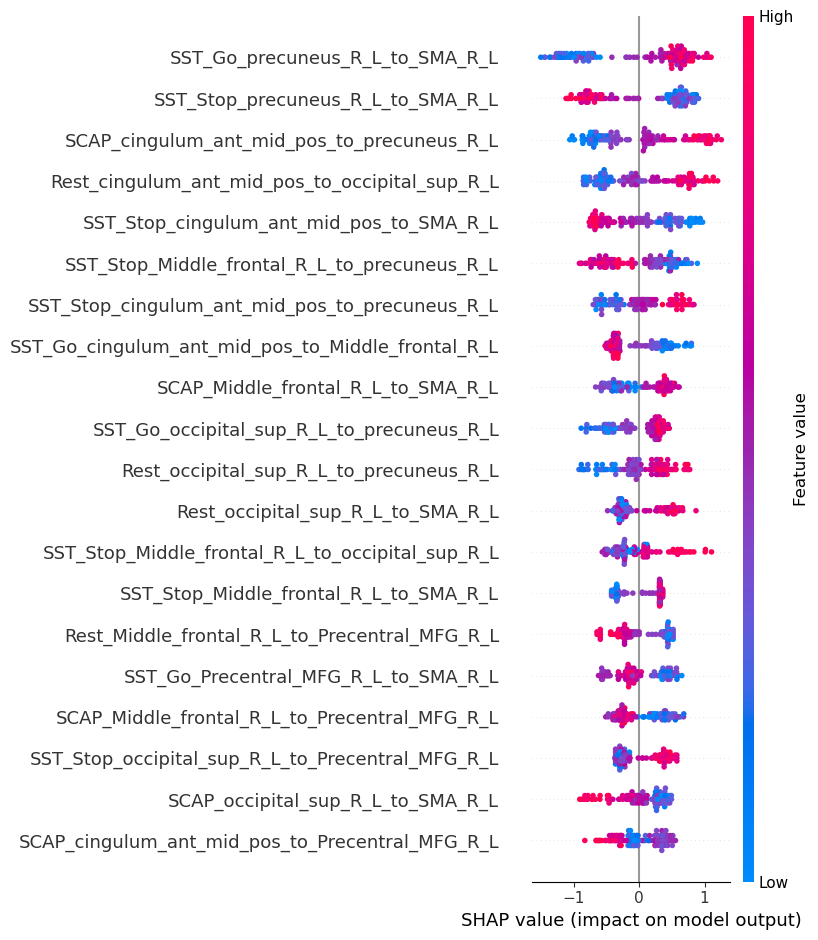

In [28]:
import shap
# === STEP 12: SHAP Interpretation ===
print("🔍 Computing SHAP values...")
explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_train)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_train, plot_type="bar", show=True)

# Beeswarm plot (detailed feature impact)
shap.summary_plot(shap_values, X_train, show=True)



**Learning curve**

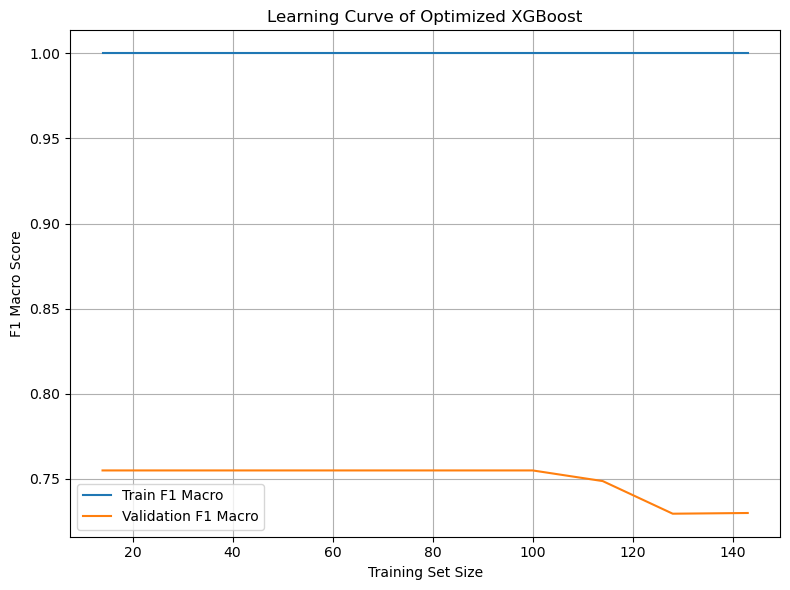

In [29]:

from sklearn.model_selection import learning_curve
# === STEP 13: Learning Curve Visualization ===
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=opt.best_estimator_,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label='Train F1 Macro')
plt.plot(train_sizes, valid_scores_mean, label='Validation F1 Macro')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Macro Score')
plt.title('Learning Curve of Optimized XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# OPTUNA

[I 2025-06-03 23:59:59,635] A new study created in memory with name: no-name-c2a70733-c673-4228-83d0-0d7f636bb6ec


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-06-04 00:00:01,420] Trial 0 finished with value: 0.49416666666666675 and parameters: {'n_estimators': 248, 'max_depth': 3, 'learning_rate': 0.06824690695208052, 'subsample': 0.8244880897977602, 'colsample_bytree': 0.7642594525682438, 'reg_alpha': 0.16085483334187023, 'reg_lambda': 9.297690841939074}. Best is trial 0 with value: 0.49416666666666675.
[I 2025-06-04 00:00:03,664] Trial 1 finished with value: 0.5097222222222222 and parameters: {'n_estimators': 296, 'max_depth': 4, 'learning_rate': 0.2744366418447248, 'subsample': 0.8175527735024661, 'colsample_bytree': 0.6507274033830012, 'reg_alpha': 0.8628211849296997, 'reg_lambda': 5.399346253378289}. Best is trial 1 with value: 0.5097222222222222.
[I 2025-06-04 00:00:07,681] Trial 2 finished with value: 0.49861111111111117 and parameters: {'n_estimators': 284, 'max_depth': 8, 'learning_rate': 0.01886725179671329, 'subsample': 0.9159259535582281, 'colsample_bytree': 0.725069337780277, 'reg_alpha': 0.2500786655002598, 'reg_lambda'

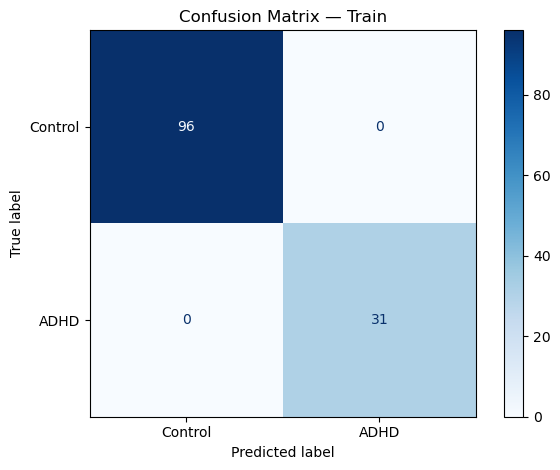

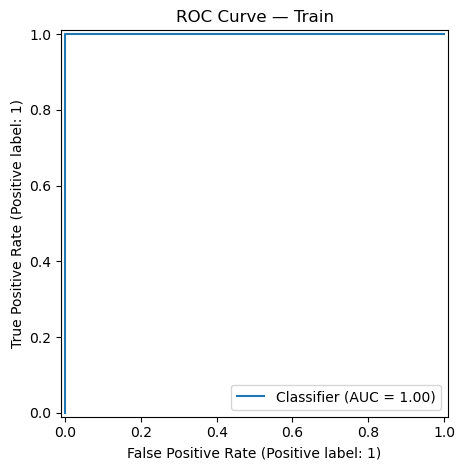

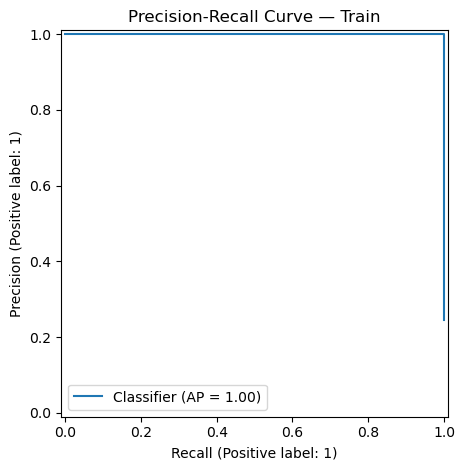


📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.77      1.00      0.87        24
        ADHD       1.00      0.12      0.22         8

    accuracy                           0.78        32
   macro avg       0.89      0.56      0.55        32
weighted avg       0.83      0.78      0.71        32

ROC AUC (Test): 0.84375


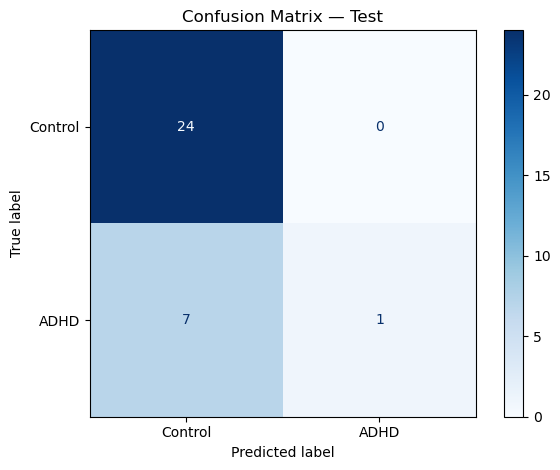

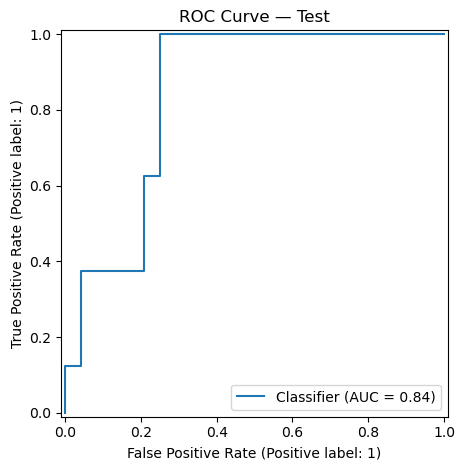

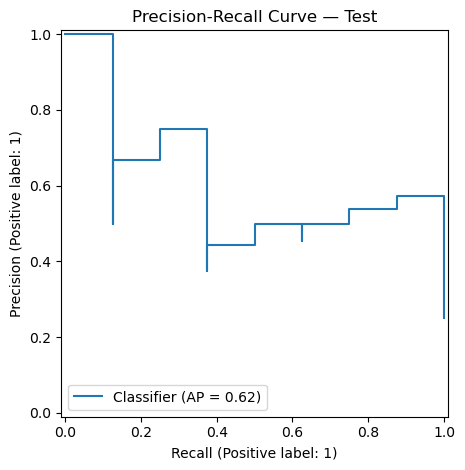

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklea


📊 Cross-Validated Scores:
fit_time: 0.2479
score_time: 0.0846
test_balanced_accuracy: 0.5167
train_balanced_accuracy: 1.0000
test_precision_macro: 0.4563
train_precision_macro: 1.0000
test_recall_macro: 0.5167
train_recall_macro: 1.0000
test_f1_macro: 0.4744
train_f1_macro: 1.0000
test_roc_auc: 0.6993
train_roc_auc: 1.0000


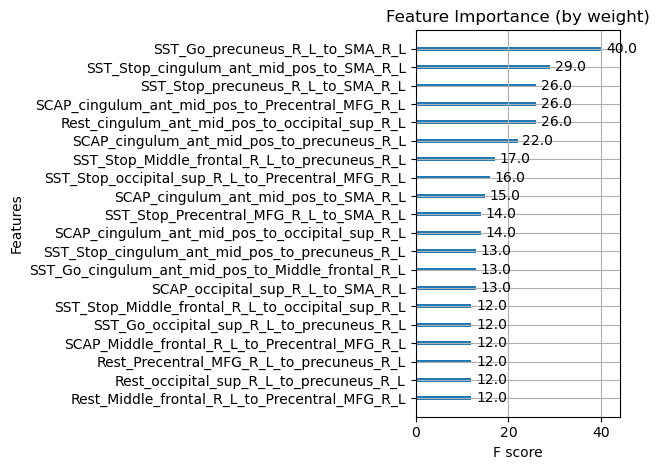

C:\Users\Saye\AppData\Local\Temp\ipykernel_4636\880299372.py:125: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


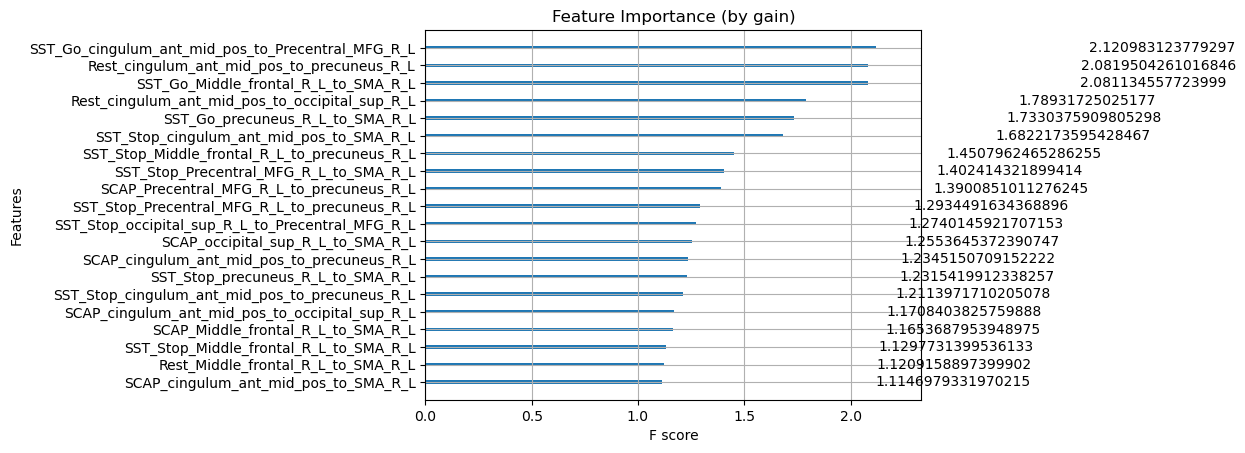

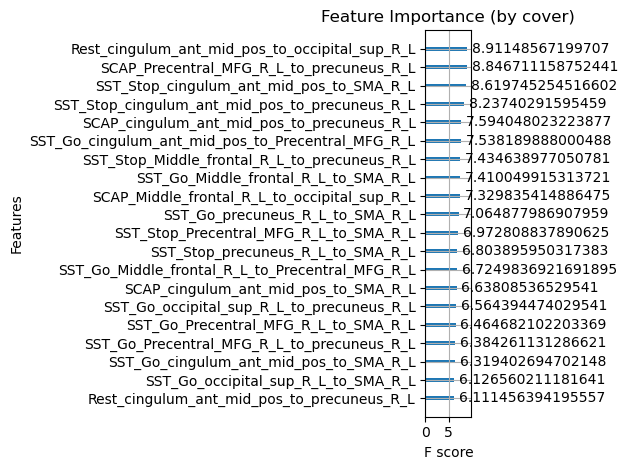

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
import xgboost as xgb

# === STEP 1: Prepare Features and Labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-Test Split ===
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# === STEP 3: Cross-Validation Strategy ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === STEP 4: Optuna Objective Function ===
def objective(trial):
    scale_pos_weight_val = (len(y_train) - sum(y_train)) / sum(y_train)

    params = {
        'booster': 'gbtree',
        'tree_method': 'auto',
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
        'scale_pos_weight': scale_pos_weight_val
    }

    model = Pipeline([
        ('xgb', xgb.XGBClassifier(**params))
    ])

    scores = cross_validate(model, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
    return scores['test_score'].mean()

# === STEP 5: Run Optuna Study ===
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

print("✅ Best Trial:")
print(study.best_trial.params)

# === STEP 6: Train Best Model ===
best_params = study.best_trial.params.copy()
best_params.update({
    'booster': 'gbtree',
    'tree_method': 'auto',
    'eval_metric': 'logloss',
    'random_state': 42
})

best_model = Pipeline([
    ('xgb', xgb.XGBClassifier(**best_params))
])

best_model.fit(X_train, y_train)

# === STEP 7: Evaluation Function ===
def evaluate_model(y_true, y_pred, y_proba, dataset="Train"):
    print(f"\n📘 Classification Report ({dataset}):")
    print(classification_report(y_true, y_pred, target_names=['Control', 'ADHD']))
    print(f"ROC AUC ({dataset}):", roc_auc_score(y_true, y_proba))

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
    plt.title(f"Confusion Matrix — {dataset}")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"ROC Curve — {dataset}")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_true, y_proba)
    plt.title(f"Precision-Recall Curve — {dataset}")
    plt.tight_layout()
    plt.show()

# === STEP 8: Train Evaluation ===
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)[:, 1]
evaluate_model(y_train, y_train_pred, y_train_proba, "Train")

# === STEP 9: Test Evaluation ===
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_test_pred, y_test_proba, "Test")

# === STEP 10: Cross-Validated Performance on All Data ===
cv_scores = cross_validate(
    best_model,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === STEP 11: Feature Importance ===
best_xgb_model = best_model.named_steps['xgb']

for importance_type in ['weight', 'gain', 'cover']:
    xgb.plot_importance(best_xgb_model, importance_type=importance_type, max_num_features=20)
    plt.title(f"Feature Importance (by {importance_type})")
    plt.tight_layout()
    plt.show()

**SHAP**


📈 SHAP Interpretation:


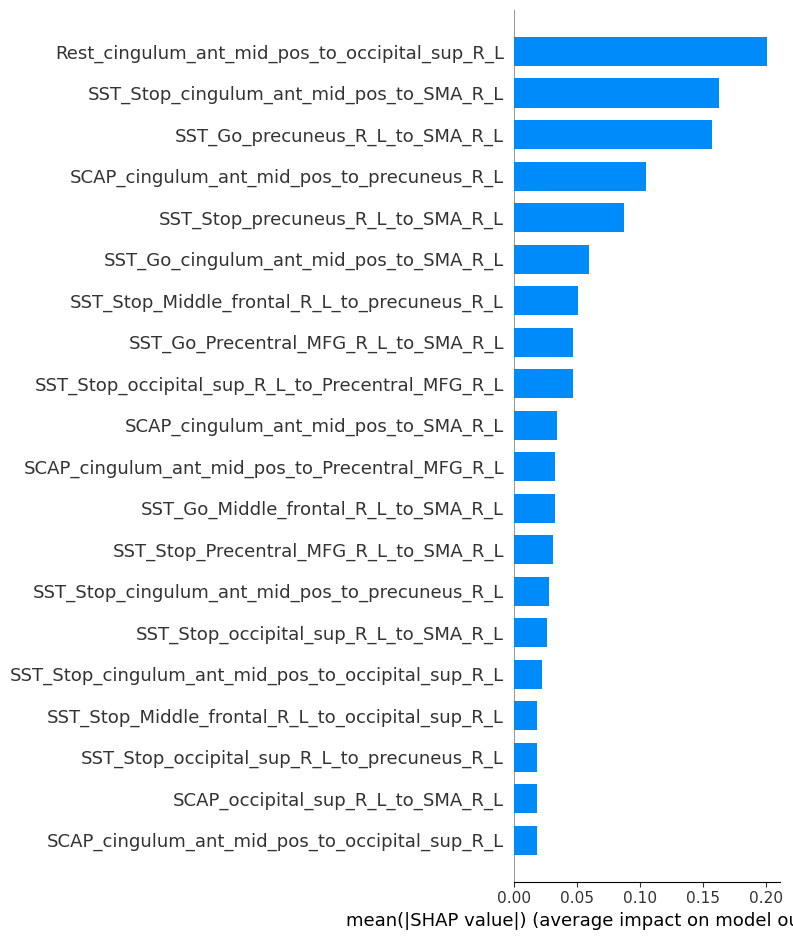

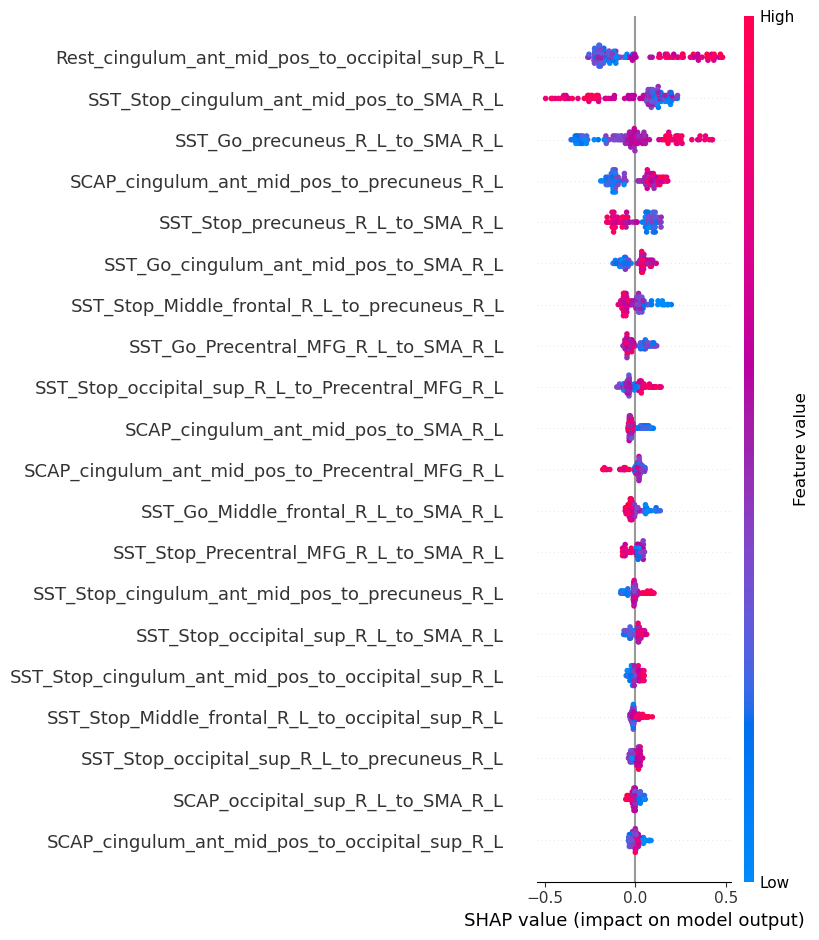

In [12]:
# === STEP 8: SHAP Interpretation ===
print("\n📈 SHAP Interpretation:")
best_xgb = best_model.named_steps['xgb']
explainer = shap.Explainer(best_xgb, X_train)
shap_values = explainer(X_train)

# Summary (global) plot
shap.summary_plot(shap_values, X_train, plot_type='bar')
shap.summary_plot(shap_values, X_train)



**Learning curve**

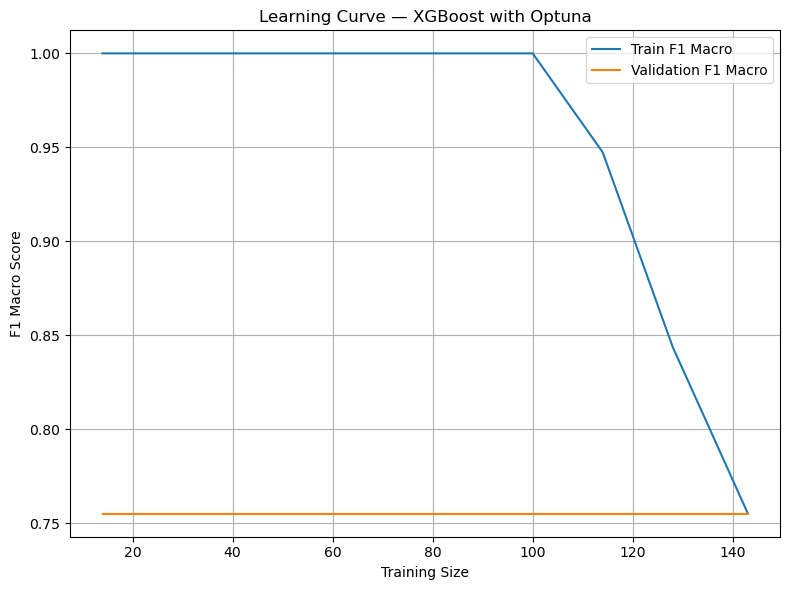

In [24]:
# === STEP 9: Learning Curve ===
train_sizes, train_scores, valid_scores = learning_curve(
    best_model, X, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = train_scores.mean(axis=1)
valid_scores_mean = valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, label="Train F1 Macro")
plt.plot(train_sizes, valid_scores_mean, label="Validation F1 Macro")
plt.xlabel("Training Size")
plt.ylabel("F1 Macro Score")
plt.title("Learning Curve — XGBoost with Optuna")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()